In [118]:
import matplotlib.pyplot as plt
import json
import numpy
from scipy.signal import find_peaks, peak_widths, lfilter, lfilter_zi, filtfilt, butter

In [119]:
def load_json(path):
    with open(path, "r") as json_file:
        return json.loads(json_file.read())
    
def smooth_without_delay(xn):
    b, a = butter(1, 0.05)
    # Apply the filter to xn.  Use lfilter_zi to choose the initial condition
    # of the filter.
    zi = lfilter_zi(b, a)
    z, _ = lfilter(b, a, xn, zi=zi*xn[0])
    # Apply the filter again, to have a result filtered at an order
    # the same as filtfilt.
    z2, _ = lfilter(b, a, z, zi=zi*z[0])
    # Use filtfilt to apply the filter.
    return filtfilt(b, a, xn)

In [152]:
VIDEO_ID = "video-31-p_09"
IAOT_PATH = "/Users/gvieira/shan/{}/data/iaot.json".format(VIDEO_ID)
intersection_area_over_time = load_json(IAOT_PATH)

1

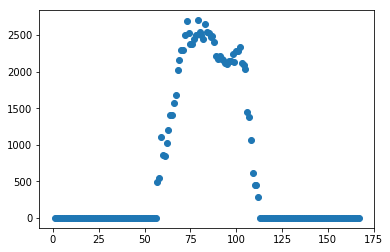

In [153]:
track_index = 0
roi_name = "middle_shelf"

iaot = intersection_area_over_time[track_index][roi_name]
X = []
Y = []
for i in range(len(iaot)):
    X.append(iaot[i]["index"])
    Y.append(iaot[i]["area"])

plt.scatter(X, Y)
iaot[0]["index"]

167

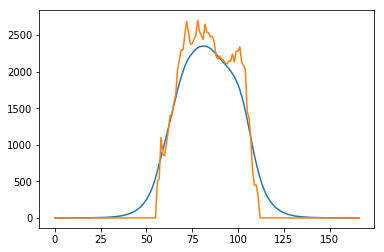

In [154]:
x = numpy.array(X)
y = numpy.array(Y)
smooth_y = smooth_without_delay(y)
plt.plot(smooth_y)
plt.plot(y)
len(smooth_y)

In [149]:
indexes, props = find_peaks(smooth_y, height=300, width=7)

peaks = []
for i in range(len(indexes)):
    frame_index = iaot[indexes[i]]["index"]
    duration_in_frames = props["widths"][i]
    intersection_area_in_pixels = props["peak_heights"][i]
    duration_ms = int(1000 * (duration_in_frames / fps))
    peaks.append({
        'frame_index': frame_index,
        'duration_in_frames': duration_in_frames,
        'intersection_area_in_pixels': intersection_area_in_pixels,
        'duration_ms': duration_ms
    })

peaks

[{'duration_in_frames': 19.580510943715808,
  'duration_ms': 1958,
  'frame_index': 686,
  'intersection_area_in_pixels': 1493.3641270887497}]

In [150]:
MIN_DURATION_MS_FOR_INTERACTED = 1800
MIN_INTERSECTION_AREA_PX_FOR_INTERACTED = 1300
fps = 10

events = []

for i in range(len(indexes)):
    frame_index = indexes[i]
    duration_in_frames = props["widths"][i]
    intersection_area_in_pixels = props["peak_heights"][i]
    
    duration_ms = int(1000 * (duration_in_frames / fps))
    if duration_ms > MIN_DURATION_MS_FOR_INTERACTED and intersection_area_in_pixels > MIN_INTERSECTION_AREA_PX_FOR_INTERACTED:
        events.append({
            "frame_index": frame_index,
            "event_type": "interacted"
        })

events

[{'event_type': 'interacted', 'frame_index': 440}]

In [146]:
def extract_walked_event(iaot, fps, min_duration, min_area):
    frame_indexes_over_time = []
    area_over_time = []
    for i in range(len(iaot)):
        frame_indexes_over_time.append(iaot[i]["index"])
        area_over_time.append(iaot[i]["area"])
    min_frames_t = int((min_duration / 1000) * fps)
    # min_frames_t = 2 sec x (10 fr / sec) = 20 frames
    for t in range(len(area_over_time)):
        if area_over_time[t] < min_area:
            continue
        small_area_found = False
        for p in range(t, min(t + min_frames_t, len(area_over_time))):
            if area_over_time[p] < min_area:
                small_area_found = True
                break
        if not small_area_found:
            return {
                "type": "walked",
                "index": frame_indexes_over_time[t]
            }
    return None

extract_walked_event(iaot, 10, 1000, 2500)